In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [6]:
df = pd.read_csv('df_out.csv')

## Data Preparation

### Data Cleaning

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

### Проверка наличия дубликатов

In [9]:
df.duplicated().unique()

array([False])

### Заполнение пропусков

In [10]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
missing_values

title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64

In [11]:
df = df[df.year.notna()]

In [12]:
df[['model', 'fuel', 'transmission']] = df[['model', 'fuel', 'transmission']].fillna('other')

In [13]:
df['title_status'] = df['title_status'].fillna(df['title_status'].mode().values[0])

In [14]:
df = df[df.lat.notna()]

In [15]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values
missing_values

<bound method Series.sort_values of id                0.0
url               0.0
region            0.0
region_url        0.0
price             0.0
year              0.0
manufacturer      0.0
model             0.0
fuel              0.0
odometer          0.0
title_status      0.0
transmission      0.0
image_url         0.0
description       0.0
state             0.0
lat               0.0
long              0.0
posting_date      0.0
price_category    0.0
date              0.0
dtype: float64>

### Преобразование типов данных

In [11]:
df['year'] = df['year'].astype(int)

In [12]:
df[['fuel', 'transmission', 'price_category']] = df[['fuel', 'transmission', 'price_category']].astype("category")

In [13]:
df['posting_date'] = pd.to_datetime(df['posting_date'], utc=True)
df['date'] = pd.to_datetime(df['date'], utc=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9868 non-null   int64              
 1   url             9868 non-null   object             
 2   region          9868 non-null   object             
 3   region_url      9868 non-null   object             
 4   price           9868 non-null   int64              
 5   year            9868 non-null   int32              
 6   manufacturer    9868 non-null   object             
 7   model           9868 non-null   object             
 8   fuel            9868 non-null   category           
 9   odometer        9868 non-null   int64              
 10  title_status    9868 non-null   object             
 11  transmission    9868 non-null   category           
 12  image_url       9868 non-null   object             
 13  description     9868 non-null   o

## Data Visualisation

### Поиск выбросов

In [15]:
df['odometer'].describe().apply(lambda x: f'{x:0.3f}')

count      9868.000
mean      93647.193
std       63260.140
min           0.000
25%       39252.500
50%       89116.000
75%      137198.250
max      283466.000
Name: odometer, dtype: object

In [16]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [17]:
boundaries_odometer = calculate_outliers(df['odometer'])
boundaries_odometer

(-107666.125, 284116.875)

In [18]:
is_outlier_odometer = (df['odometer'] < boundaries_odometer[0]) | (df['odometer'] > boundaries_odometer[1])
is_outlier_odometer

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: odometer, Length: 9868, dtype: bool

In [19]:
is_outlier_odometer.sum()

0

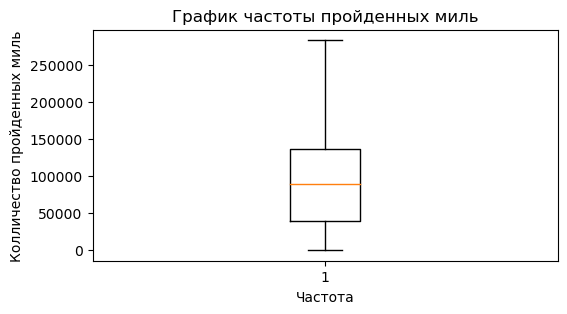

In [20]:
plt.figure(figsize=(6,3))
plt.boxplot(df.odometer)
plt.xlabel('Частота')
plt.ylabel('Колличество пройденных миль')
plt.title('График частоты пройденных миль');

### Выбросы в столбце odometer отсутствуют

In [21]:
df['year'].describe().apply(lambda x: f'{x:0.3f}')

count    9868.000
mean     2010.910
std         9.706
min      1915.000
25%      2008.000
50%      2013.000
75%      2017.000
max      2022.000
Name: year, dtype: object

In [22]:
boundaries_year = calculate_outliers(df['year'])
boundaries_year

(1994.5, 2030.5)

In [23]:
is_outlier_year = (df['year'] < boundaries_year[0]) | (df['year'] > boundaries_year[1])
is_outlier_year

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: year, Length: 9868, dtype: bool

In [24]:
is_outlier_year.sum()

394

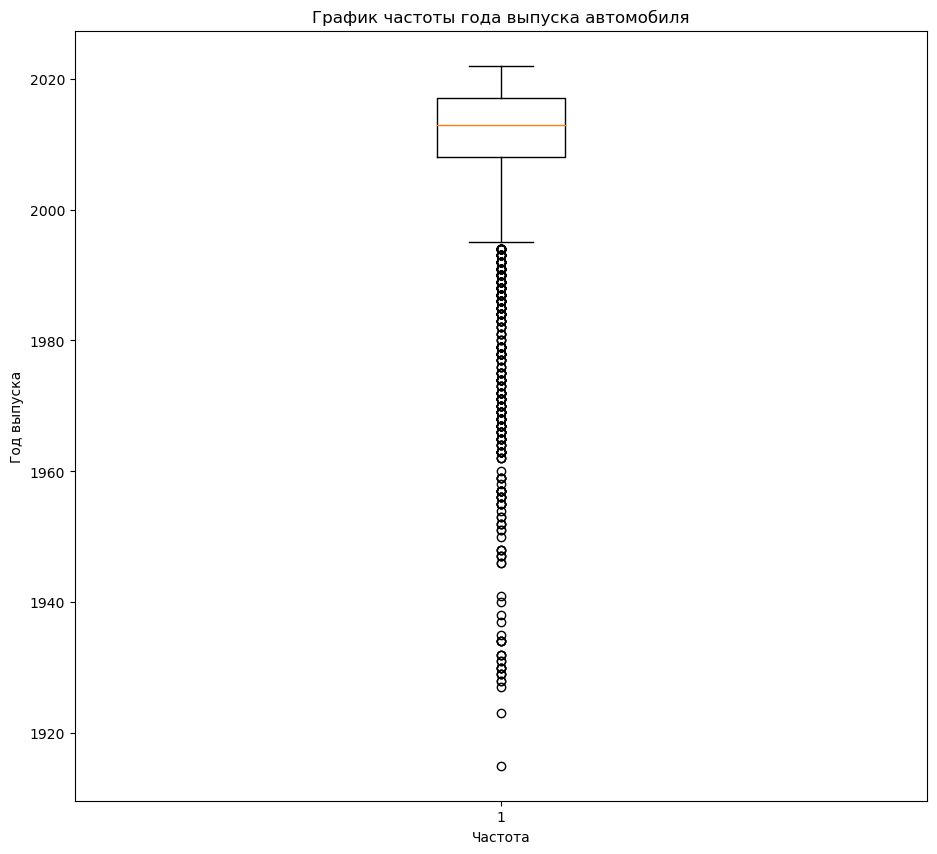

In [25]:
plt.figure(figsize=(11,10))
plt.boxplot(df.year)
plt.xlabel('Частота')
plt.ylabel('Год выпуска')
plt.title('График частоты года выпуска автомобиля');

### Удалим выбросы в годе выпуска

In [26]:
df = df[~(df['year'] < boundaries_year[0]) | (df['year'] > boundaries_year[1])]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9474 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9474 non-null   int64              
 1   url             9474 non-null   object             
 2   region          9474 non-null   object             
 3   region_url      9474 non-null   object             
 4   price           9474 non-null   int64              
 5   year            9474 non-null   int32              
 6   manufacturer    9474 non-null   object             
 7   model           9474 non-null   object             
 8   fuel            9474 non-null   category           
 9   odometer        9474 non-null   int64              
 10  title_status    9474 non-null   object             
 11  transmission    9474 non-null   category           
 12  image_url       9474 non-null   object             
 13  description     9474 non-null   o

## Feature enginering

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9474 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9474 non-null   int64              
 1   url             9474 non-null   object             
 2   region          9474 non-null   object             
 3   region_url      9474 non-null   object             
 4   price           9474 non-null   int64              
 5   year            9474 non-null   int32              
 6   manufacturer    9474 non-null   object             
 7   model           9474 non-null   object             
 8   fuel            9474 non-null   category           
 9   odometer        9474 non-null   int64              
 10  title_status    9474 non-null   object             
 11  transmission    9474 non-null   category           
 12  image_url       9474 non-null   object             
 13  description     9474 non-null   o

### Генерация строковых фичей

In [30]:
df['desc_len'] = df.apply(lambda x: len(x.description) , axis=1)

In [31]:
df['short_model'] = df.apply(lambda x: x.model.split(' ')[0], axis=1)

In [32]:
df['age_category'] = df.apply(lambda x: 'new' if x.year>2014 else('old' if x.year<2006 else 'average'), axis=1)

In [33]:
df['age_category'] = df['age_category'].astype("category")

In [34]:
df['diff_years'] = df.apply(lambda x: x.date.year - x.year, axis=1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9474 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9474 non-null   int64              
 1   url             9474 non-null   object             
 2   region          9474 non-null   object             
 3   region_url      9474 non-null   object             
 4   price           9474 non-null   int64              
 5   year            9474 non-null   int32              
 6   manufacturer    9474 non-null   object             
 7   model           9474 non-null   object             
 8   fuel            9474 non-null   category           
 9   odometer        9474 non-null   int64              
 10  title_status    9474 non-null   object             
 11  transmission    9474 non-null   category           
 12  image_url       9474 non-null   object             
 13  description     9474 non-null   o

### Преобразование категориальных данных

In [36]:
category_var = df[['fuel', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'short_model', 'age_category']]

In [37]:
ohe = OneHotEncoder(sparse=False)

In [38]:
ohe.fit(category_var)

C:\Users\Pavel\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [39]:
ohe_cat_var = ohe.transform(category_var)

In [ ]:
df[ohe.get_feature_names_out()] = ohe_cat_var

### Стандартизация данных

In [41]:
std_data = df[['lat', 'long', 'year', 'desc_len', 'odometer', 'diff_years']]

In [42]:
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [43]:
std_scaler.fit(std_data)

StandardScaler()

In [44]:
std_scaler_var = std_scaler.transform(std_data)
std_scaler_var

array([[-0.60423595,  0.48442278,  1.36815251,  0.58318934, -1.05783949,
        -1.36815251],
       [ 0.38213527,  1.10268853,  0.64875764, -0.67774721, -0.54205115,
        -0.64875764],
       [-0.82349545,  0.53074221,  0.82860636,  0.51285822, -1.2698793 ,
        -0.82860636],
       ...,
       [ 1.08472223, -1.60073898, -0.25048594, -0.69891831,  0.88528357,
         0.25048594],
       [ 0.76008367,  0.25521009,  0.46890892,  0.28248791, -0.51165572,
        -0.46890892],
       [-0.32861787,  0.97901159,  0.82860636,  0.58354817, -0.92360882,
        -0.82860636]])

In [45]:
std_scaler.feature_names_in_ = ['lat_std', 'long_std', 'year_std', 'desc_len_std', 'odometer_std', 'diff_years_std']

In [46]:
df[std_scaler.get_feature_names_out()] = std_scaler_var

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9474 entries, 0 to 9999
Columns: 1367 entries, id to diff_years_std
dtypes: category(4), datetime64[ns, UTC](2), float64(1345), int32(1), int64(5), object(10)
memory usage: 98.6+ MB


### Удаление фичей не нужных для моделирования

In [48]:
df = df.drop(['id','url', 'year', 'region', 'region_url', 'manufacturer',  'state',
                    'model', 'fuel', 'odometer', 'title_status', 'transmission',
                    'image_url', 'description', 'lat', 'long', 'posting_date',
              'date', 'short_model', 'desc_len', 'diff_years', 'age_category'], axis=1)

In [49]:
df.to_csv('vehicles_dataset_prepared_my.csv', index=False)

## Modeling

In [50]:
df_prepared = pd.read_csv('vehicles_dataset_prepared_my.csv')

In [51]:
x = df_prepared.drop(['price_category', 'price'], axis=1)
y = df_prepared['price_category']

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Модель Случайного леса

In [53]:
rf_clf = RandomForestClassifier(n_estimators=250, bootstrap=True)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=250)

In [54]:
predict_train_rf = rf_clf.predict(x_train)
predict_test_rf = rf_clf.predict(x_test)

In [55]:
print(accuracy_score(y_train, predict_train_rf))
print(accuracy_score(y_test, predict_test_rf))
print(confusion_matrix(y_test, predict_test_rf))

1.0
0.7903622933520928
[[871  13 107]
 [ 23 777 112]
 [169 172 599]]


### Модель Логистической регрессии

In [56]:
log_reg = LogisticRegression(max_iter=200, penalty='l2', solver='newton-cg', C=10)
log_reg.fit(x_train, y_train)

LogisticRegression(C=10, max_iter=200, solver='newton-cg')

In [57]:
predict_train_log = log_reg.predict(x_train)
predict_test_log = log_reg.predict(x_test)

In [58]:
print(accuracy_score(y_train, predict_train_log))
print(accuracy_score(y_test, predict_test_log))
print(confusion_matrix(y_test, predict_test_log))

0.9040868647262856
0.7991558213155118
[[859   6 126]
 [ 25 763 124]
 [146 144 650]]


### Модель многослойный пропестрон

In [639]:
mlp = MLPClassifier(max_iter=300, hidden_layer_sizes=(100, 20))
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 20), max_iter=300)

In [640]:
predict_train_mlp = mlp.predict(x_train)
predict_test_mlp = mlp.predict(x_test)

In [641]:
print(accuracy_score(y_train, predict_train_mlp))
print(accuracy_score(y_test, predict_test_mlp))
print(confusion_matrix(y_test, predict_test_mlp))

0.9996983863670638
0.7791065775589167
[[840  13 125]
 [ 26 732 163]
 [142 159 643]]


In [664]:
filename = '28_pw_model_mlp.pickle'

with open(filename, 'wb') as file:
    pickle.dump(mlp, file)

### Сравнение моделей

In [642]:
cv_score_rf = cross_val_score(rf_clf, x, y, cv=5)
cv_score_log = cross_val_score(log_reg, x, y, cv=5)
cv_score_mlp = cross_val_score(mlp, x, y, cv=5)

In [647]:
print(cv_score_rf)
cv_score_rf.mean(), cv_score_rf.std()

[0.79050132 0.7878628  0.7883905  0.80211082 0.77983105]


(0.7897392961525495, 0.007171459553607525)

In [648]:
print(cv_score_log)
cv_score_log.mean(), cv_score_log.std()

[0.80686016 0.79577836 0.80527704 0.80633245 0.80147835]


(0.8031452747601786, 0.004136494060167725)

In [649]:
print(cv_score_mlp)
cv_score_mlp.mean(), cv_score_mlp.std()

[0.80158311 0.79577836 0.79313984 0.79630607 0.80147835]


(0.7976571481111021, 0.0033399434367288403)

По результатам сравнения выбираем модель логистической регресии

In [651]:
print(accuracy_score(y_train, predict_train_log))
print(accuracy_score(y_test, predict_test_log))

0.9048408988086262
0.7935279634189236


Модель показывает стабильные результаты на тестовых фоладах, при этом качество модели на тестовой выборке не сильно отличается, модель не переобучилась.

## Results

Все три объявленные модели имеют близкие результаты, однако, сравнив модели при помощи кросс валидации было выявлено,
что модель  логистической регресии имеет самую высокую предсказательную способность.

In [652]:
log_reg = LogisticRegression(max_iter=200, penalty='l2', solver='newton-cg', C=10)
log_reg.fit(x, y)

LogisticRegression(C=10, max_iter=200, solver='newton-cg')

In [654]:
filename = '28_pw_model.pickle'

with open(filename, 'wb') as file:
    pickle.dump(log_reg, file)